# Hands-on Activity 8.1: Aggregating Data with Pandas

**8.1.1 Intended Learning Outcomes**

After this activity, the student should be able to:

- Demonstrate querying and merging of dataframes
- Perform advanced calculations on dataframes
- Aggregate dataframes with pandas and numpy
- Work with time series data

**8.1.2 Resources**

- Computing Environment using 3.x
- Attached Datasets (under Instructional Materials)

**8.1.3 Procedures**

The procedures can be found in the Canvas module. Check the following under topics:

- 8.1 Weather Data Collection

In [10]:
import requests

def make_request (endpoint, payload=None):
    """
    Make a request to a specific endpoint on the weather API
    passing headers and optional payload.

    Parameters:
        - endpoint: The endpoint of the API you want to make a GET request to.
        - payload: A dictionary of data to pass along
                   with the request.
    Returns:
        Response object.
    """
    return requests.get(
        f'https://www.ncdc.noaa.gov/cdo-web/api/v2/{endpoint}',
    headers={
        'token': 'OFnSHHJclcVZDUVdzLGZqFfxjoZlNYpe'
    },
    params=payload
    )

In [14]:
import datetime

from IPython import display # for updating the cell dynamically

current = datetime.date(2018, 1,1)
end= datetime.date(2019,1,1)

results = [] # save the results in a list

while current < end:
    # Update the cell with status information
    display.clear_output(wait=True)
    display.display(f'Gathering data for {str(current)}')

    response = make_request('data',
            {
                'datasetid': 'GHCND', # Global Historical Climatology Network - Daily (GHCND) dataset
                'locationid' : 'CITY:US360019', # New York City
                'startdate' : current,
                'enddate': current,
                'units' : 'metric',
                'limit' : 1000 # max allowed
            }
                           )

    if response.ok:
        # We extend the list instead of appending to avoid getting a nested list
        results.extend(response.json()['results'])

    # update the current date to avoid an infinite loop
    current += datetime.timedelta(days=1)

'Gathering data for 2018-12-31'

In [15]:
import pandas as pd

df = pd.DataFrame(results)
df.head()

,date,datatype,station,attributes,value
0,2018-01-01T00:00:00,PRCP,GHCND:US1CTFR0039,",,N,0800",0.0
1,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0015,",,N,1050",0.0
2,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0015,",,N,1050",0.0
3,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0017,",,N,0920",0.0
4,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0017,",,N,0920",0.0


In [935]:
df.to_csv('C:/Users/paala/CPE311 - Paala/nyc_weather_2018.csv', index=False)

In [973]:
import sqlite3

with sqlite3.connect('weather.db') as connection: # This will create a Database which will be saved in the folder
    df.to_sql(
        'weather', connection, index=False, if_exists='replace'
    )

In [975]:
response = make_request(
    'stations',
    {
        'datasetid' : 'GHCND', # Global Historical Climatology Network - Daily (GHCND) dataset
        'locationid' : 'CITY:US360019', # NYC
        'limit' : 1000 # max allowed
    }
)

stations = pd.DataFrame(response.json()['results'])[['id', 'name', 'latitude', 'longitude', 'elevation']]
stations.to_csv('C:/Users/paala/CPE311 - Paala/weather_stations.csv', index=False)

with sqlite3.connect('weather.db') as connection:
    stations.to_sql(
        'stations', connection, index=False, if_exists='replace'
    )

- 8.2 Querying and Merging

In [977]:
import pandas as pd

weather = pd.read_csv('C:/Users/paala/CPE311 - Paala/nyc_weather_2018.csv')
weather.head()

,date,datatype,station,attributes,value
0,2018-01-01T00:00:00,PRCP,GHCND:US1CTFR0039,",,N,0800",0.0
1,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0015,",,N,1050",0.0
2,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0015,",,N,1050",0.0
3,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0017,",,N,0920",0.0
4,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0017,",,N,0920",0.0


In [978]:
snow_data = weather.query('datatype == "SNOW" and value > 0')
snow_data.head()

,date,datatype,station,attributes,value
127,2018-01-01T00:00:00,SNOW,GHCND:US1NYWC0019,",,N,1700",25.0
816,2018-01-04T00:00:00,SNOW,GHCND:US1NJBG0015,",,N,1600",229.0
819,2018-01-04T00:00:00,SNOW,GHCND:US1NJBG0017,",,N,0830",10.0
823,2018-01-04T00:00:00,SNOW,GHCND:US1NJBG0018,",,N,0910",46.0
830,2018-01-04T00:00:00,SNOW,GHCND:US1NJES0018,",,N,0700",10.0


In [982]:
import sqlite3

with sqlite3.connect('C:/Users/paala/CPE311 - Paala/weather.db') as connection:
    snow_data_from_db = pd.read_sql(
        'SELECT * FROM weather WHERE datatype == "SNOW" AND value > 0', 
        connection
    )

snow_data.reset_index().drop(columns='index').equals(snow_data_from_db)

True

In [984]:
weather[(weather.datatype == 'SNOW') & (weather.value > 0)].equals(snow_data)

True

In [971]:
station_info = pd.read_csv('C:/Users/paala/CPE311 - Paala/weather_stations.csv')
station_info.head()

,id,name,latitude,longitude,elevation
0,GHCND:US1CTFR0022,"STAMFORD 2.6 SSW, CT US",41.064100,-73.577000,36.6
1,GHCND:US1CTFR0039,"STAMFORD 4.2 S, CT US",41.037788,-73.568176,6.4
2,GHCND:US1NJBG0001,"BERGENFIELD 0.3 SW, NJ US",40.921298,-74.001983,20.1
3,GHCND:US1NJBG0002,"SADDLE BROOK TWP 0.6 E, NJ US",40.902694,-74.083358,16.8
4,GHCND:US1NJBG0003,"TENAFLY 1.3 W, NJ US",40.914670,-73.977500,21.6


In [986]:
weather.head()

,date,datatype,station,attributes,value
0,2018-01-01T00:00:00,PRCP,GHCND:US1CTFR0039,",,N,0800",0.0
1,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0015,",,N,1050",0.0
2,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0015,",,N,1050",0.0
3,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0017,",,N,0920",0.0
4,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0017,",,N,0920",0.0


In [988]:
station_info.id.describe()

count                   330
unique                  330
top       GHCND:US1CTFR0022
freq                      1
Name: id, dtype: object

In [990]:
weather.station.describe()

count                 90734
unique                  114
top       GHCND:USW00014734
freq                   6702
Name: station, dtype: object

In [992]:
station_info.shape[0], weather.shape[0]

(330, 90734)

In [994]:
def get_row_count(*dfs):
    return [df.shape[0] for df in dfs]
get_row_count(station_info, weather)

[330, 90734]

In [996]:
def get_info(attr, *dfs):
    return list(map(lambda x: getattr(x, attr), dfs))
get_info('shape', station_info, weather)

[(330, 5), (90734, 5)]

In [998]:
inner_join = weather.merge(station_info, left_on='station', right_on='id')
inner_join.sample(5, random_state=0)

,date,datatype,station,attributes,value,id,name,latitude,longitude,elevation
57955,2018-08-21T00:00:00,TMAX,GHCND:USW00094728,",,W,2400",26.1,GHCND:USW00094728,"NY CITY CENTRAL PARK, NY US",40.77898,-73.969250,42.7
49057,2018-07-13T00:00:00,RHMN,GHCND:USW00014734,",,W,",35.0,GHCND:USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",40.68275,-74.169270,1.9
54008,2018-08-05T00:00:00,SNWD,GHCND:US1NYWC0018,",,N,0800",0.0,GHCND:US1NYWC0018,"ARMONK 0.3 SE, NY US",41.12996,-73.708161,117.3
18820,2018-03-14T00:00:00,TMAX,GHCND:USC00289187,",,7,0700",0.6,GHCND:USC00289187,"WANAQUE RAYMOND DAM, NJ US",41.04156,-74.297180,71.9
38525,2018-05-30T00:00:00,ASLP,GHCND:USW00014734,",,W,",10196.0,GHCND:USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",40.68275,-74.169270,1.9


In [1000]:
weather.merge(station_info.rename(dict(id='station'), axis=1), on='station').sample(5, random_state=0)


,date,datatype,station,attributes,value,name,latitude,longitude,elevation
57955,2018-08-21T00:00:00,TMAX,GHCND:USW00094728,",,W,2400",26.1,"NY CITY CENTRAL PARK, NY US",40.77898,-73.969250,42.7
49057,2018-07-13T00:00:00,RHMN,GHCND:USW00014734,",,W,",35.0,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",40.68275,-74.169270,1.9
54008,2018-08-05T00:00:00,SNWD,GHCND:US1NYWC0018,",,N,0800",0.0,"ARMONK 0.3 SE, NY US",41.12996,-73.708161,117.3
18820,2018-03-14T00:00:00,TMAX,GHCND:USC00289187,",,7,0700",0.6,"WANAQUE RAYMOND DAM, NJ US",41.04156,-74.297180,71.9
38525,2018-05-30T00:00:00,ASLP,GHCND:USW00014734,",,W,",10196.0,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",40.68275,-74.169270,1.9


In [1002]:
left_join = station_info.merge(weather, left_on='id', right_on='station', how='left')
right_join = weather.merge(station_info, left_on='station', right_on='id', how='right')
right_join.tail()

,date,datatype,station,attributes,value,id,name,latitude,longitude,elevation
90945,2018-12-31T00:00:00,WDF5,GHCND:USW00094789,",,W,",130.0,GHCND:USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",40.63915,-73.7639,2.7
90946,2018-12-31T00:00:00,WSF2,GHCND:USW00094789,",,W,",9.8,GHCND:USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",40.63915,-73.7639,2.7
90947,2018-12-31T00:00:00,WSF5,GHCND:USW00094789,",,W,",12.5,GHCND:USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",40.63915,-73.7639,2.7
90948,2018-12-31T00:00:00,WT01,GHCND:USW00094789,",,W,",1.0,GHCND:USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",40.63915,-73.7639,2.7
90949,2018-12-31T00:00:00,WT02,GHCND:USW00094789,",,W,",1.0,GHCND:USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",40.63915,-73.7639,2.7


In [1006]:
left_join.sort_index(axis=1).sort_values(['date', 'station']).reset_index().drop(columns='index').equals(
        right_join.sort_index(axis=1).sort_values(['date', 'station']).reset_index().drop(columns='index')
)

True

In [1008]:
get_info('shape', inner_join, left_join, right_join)

[(90734, 10), (90950, 10), (90950, 10)]

In [1014]:
outer_join = weather.merge(
            station_info[station_info.name.str.contains('NY')],
            left_on='station', right_on='id', how='outer', indicator=True
)

pd.concat([
    outer_join.sample(4, random_state=0),
    outer_join[outer_join.station.isna()].head(2)
]) # the append function is no longer working.

,date,datatype,station,attributes,value,id,name,latitude,longitude,elevation,_merge
28316,2018-01-12T00:00:00,PRCP,GHCND:US1NYNS0030,",,N,0800",0.3,GHCND:US1NYNS0030,"PLAINEDGE 0.4 WSW, NY US",40.721382,-73.484241,22.9,both
26729,2018-02-02T00:00:00,SNOW,GHCND:US1NYNS0007,"T,,N,0700",0.0,GHCND:US1NYNS0007,"FLORAL PARK 0.4 W, NY US",40.723000,-73.710999,24.1,both
24134,2018-11-15T00:00:00,PRCP,GHCND:US1NJUN0003,",,N,0730",0.0,NaN,NaN,NaN,NaN,NaN,left_only
48179,2018-01-18T00:00:00,TOBS,GHCND:USC00301309,",,7,0700",-8.3,GHCND:USC00301309,"CENTERPORT, NY US",40.883450,-73.373090,9.1,both
7101,NaN,NaN,NaN,NaN,NaN,GHCND:US1NJHD0018,"KEARNY 1.7 NNW, NJ US",40.774342,-74.137109,25.6,right_only
15031,NaN,NaN,NaN,NaN,NaN,GHCND:US1NJMS0036,"PARSIPPANY TROY HILLS TWP 2.1 E, NJ US",40.865600,-74.385100,64.3,right_only


In [1018]:
import sqlite3

with sqlite3.connect('C:/Users/paala/CPE311 - Paala/weather.db') as connection:
    inner_join_from_db = pd.read_sql(
        'SELECT * FROM weather JOIN stations ON weather.station == stations.id',
        connection
)
inner_join_from_db.shape == inner_join.shape

True

In [1024]:
dirty_data = pd.read_csv(
    'C:/Users/paala/CPE311 - Paala/dirty_data.csv', index_col='date'
).drop_duplicates().drop(columns='SNWD')
dirty_data.head()

,station,PRCP,SNOW,TMAX,TMIN,TOBS,WESF,inclement_weather
date,,,,,,,,
2018-01-01T00:00:00,?,0.0,0.0,5505.0,-40.0,NaN,NaN,NaN
2018-01-02T00:00:00,GHCND:USC00280907,0.0,0.0,-8.3,-16.1,-12.2,NaN,False
2018-01-03T00:00:00,GHCND:USC00280907,0.0,0.0,-4.4,-13.9,-13.3,NaN,False
2018-01-04T00:00:00,?,20.6,229.0,5505.0,-40.0,NaN,19.3,True
2018-01-05T00:00:00,?,0.3,NaN,5505.0,-40.0,NaN,NaN,NaN


In [1026]:
valid_station = dirty_data.query('station != "?"').copy().drop(columns=['WESF', 'station'])
station_with_wesf = dirty_data.query('station == "?"').copy().drop(columns=['station', 'TOBS', 'TMIN', 'TMAX'])

In [1028]:
valid_station.merge(
    station_with_wesf, left_index=True, right_index=True
).query('WESF > 0').head()

,PRCP_x,SNOW_x,TMAX,TMIN,TOBS,inclement_weather_x,PRCP_y,SNOW_y,WESF,inclement_weather_y
date,,,,,,,,,,
2018-01-30T00:00:00,0.0,0.0,6.7,-1.7,-0.6,False,1.5,13.0,1.8,True
2018-03-08T00:00:00,48.8,NaN,1.1,-0.6,1.1,False,28.4,NaN,28.7,NaN
2018-03-13T00:00:00,4.1,51.0,5.6,-3.9,0.0,True,3.0,13.0,3.0,True
2018-03-21T00:00:00,0.0,0.0,2.8,-2.8,0.6,False,6.6,114.0,8.6,True
2018-04-02T00:00:00,9.1,127.0,12.8,-1.1,-1.1,True,14.0,152.0,15.2,True


In [1030]:
valid_station.merge(
    station_with_wesf, left_index=True, right_index=True, suffixes=('', '_?')
).query('WESF > 0').head()

,PRCP,SNOW,TMAX,TMIN,TOBS,inclement_weather,PRCP_?,SNOW_?,WESF,inclement_weather_?
date,,,,,,,,,,
2018-01-30T00:00:00,0.0,0.0,6.7,-1.7,-0.6,False,1.5,13.0,1.8,True
2018-03-08T00:00:00,48.8,NaN,1.1,-0.6,1.1,False,28.4,NaN,28.7,NaN
2018-03-13T00:00:00,4.1,51.0,5.6,-3.9,0.0,True,3.0,13.0,3.0,True
2018-03-21T00:00:00,0.0,0.0,2.8,-2.8,0.6,False,6.6,114.0,8.6,True
2018-04-02T00:00:00,9.1,127.0,12.8,-1.1,-1.1,True,14.0,152.0,15.2,True


In [1032]:
valid_station.join(station_with_wesf, rsuffix='_?').query('WESF > 0').head()

,PRCP,SNOW,TMAX,TMIN,TOBS,inclement_weather,PRCP_?,SNOW_?,WESF,inclement_weather_?
date,,,,,,,,,,
2018-01-30T00:00:00,0.0,0.0,6.7,-1.7,-0.6,False,1.5,13.0,1.8,True
2018-03-08T00:00:00,48.8,NaN,1.1,-0.6,1.1,False,28.4,NaN,28.7,NaN
2018-03-13T00:00:00,4.1,51.0,5.6,-3.9,0.0,True,3.0,13.0,3.0,True
2018-03-21T00:00:00,0.0,0.0,2.8,-2.8,0.6,False,6.6,114.0,8.6,True
2018-04-02T00:00:00,9.1,127.0,12.8,-1.1,-1.1,True,14.0,152.0,15.2,True


In [1034]:
weather.set_index('station', inplace=True)
station_info.set_index('id', inplace=True)

In [1036]:
weather.index.intersection(station_info.index)

Index(['GHCND:US1CTFR0039', 'GHCND:US1NJBG0015', 'GHCND:US1NJBG0017',
       'GHCND:US1NJBG0018', 'GHCND:US1NJBG0023', 'GHCND:US1NJBG0030',
       'GHCND:US1NJBG0039', 'GHCND:US1NJBG0044', 'GHCND:US1NJES0018',
       'GHCND:US1NJES0024',
       ...
       'GHCND:USC00284987', 'GHCND:US1NJES0031', 'GHCND:US1NJES0029',
       'GHCND:US1NJMD0086', 'GHCND:US1NJMS0097', 'GHCND:US1NJMN0081',
       'GHCND:US1NJMD0088', 'GHCND:US1NJES0033', 'GHCND:US1NJES0040',
       'GHCND:US1NYQN0029'],
      dtype='object', length=114)

In [1038]:
weather.index.difference(station_info.index)

Index([], dtype='object')

In [1040]:
station_info.index.difference(weather.index)

Index(['GHCND:US1CTFR0022', 'GHCND:US1NJBG0001', 'GHCND:US1NJBG0002',
       'GHCND:US1NJBG0005', 'GHCND:US1NJBG0006', 'GHCND:US1NJBG0008',
       'GHCND:US1NJBG0011', 'GHCND:US1NJBG0012', 'GHCND:US1NJBG0013',
       'GHCND:US1NJBG0020',
       ...
       'GHCND:USC00308749', 'GHCND:USC00308946', 'GHCND:USC00309117',
       'GHCND:USC00309270', 'GHCND:USC00309400', 'GHCND:USC00309466',
       'GHCND:USC00309576', 'GHCND:USC00309580', 'GHCND:USW00014708',
       'GHCND:USW00014786'],
      dtype='object', length=216)

In [1042]:
ny_in_name = station_info[station_info.name.str.contains('NY')]
ny_in_name.index.difference(weather.index).shape[0]\
+ weather.index.difference(ny_in_name.index).shape[0]\
== weather.index.symmetric_difference(ny_in_name.index).shape[0]

True

In [1044]:
weather.index.unique().union(station_info.index)

Index(['GHCND:US1CTFR0022', 'GHCND:US1CTFR0039', 'GHCND:US1NJBG0001',
       'GHCND:US1NJBG0002', 'GHCND:US1NJBG0003', 'GHCND:US1NJBG0005',
       'GHCND:US1NJBG0006', 'GHCND:US1NJBG0008', 'GHCND:US1NJBG0010',
       'GHCND:US1NJBG0011',
       ...
       'GHCND:USW00014708', 'GHCND:USW00014732', 'GHCND:USW00014734',
       'GHCND:USW00014786', 'GHCND:USW00054743', 'GHCND:USW00054787',
       'GHCND:USW00094728', 'GHCND:USW00094741', 'GHCND:USW00094745',
       'GHCND:USW00094789'],
      dtype='object', length=330)

In [1046]:
ny_in_name = station_info[station_info.name.str.contains('NY')]

ny_in_name.index.difference(weather.index).union(weather.index.difference(ny_in_name.index)).equals(
    weather.index.symmetric_difference(ny_in_name.index)
)

True

- 8.3 Dataframe Operations

In [1048]:
import numpy as np
import pandas as pd
weather = pd.read_csv('C:/Users/paala/CPE311 - Paala/nyc_weather_2018.csv', parse_dates=['date'])
weather.head()

,date,datatype,station,attributes,value
0,2018-01-01,PRCP,GHCND:US1CTFR0039,",,N,0800",0.0
1,2018-01-01,PRCP,GHCND:US1NJBG0015,",,N,1050",0.0
2,2018-01-01,SNOW,GHCND:US1NJBG0015,",,N,1050",0.0
3,2018-01-01,PRCP,GHCND:US1NJBG0017,",,N,0920",0.0
4,2018-01-01,SNOW,GHCND:US1NJBG0017,",,N,0920",0.0


In [1054]:
fb = pd.read_csv('C:/Users/paala/CPE311 - Paala/fb_2018.csv', index_col='date', parse_dates=True)
fb.head()

,open,high,low,close,volume
date,,,,,
2018-01-02,177.68,181.58,177.5500,181.42,18151903
2018-01-03,181.88,184.78,181.3300,184.67,16886563
2018-01-04,184.90,186.21,184.0996,184.33,13880896
2018-01-05,185.59,186.90,184.9300,186.85,13574535
2018-01-08,187.20,188.90,186.3300,188.28,17994726


In [1056]:
fb.assign(
    abs_z_score_volume=lambda x: x.volume.sub(x.volume.mean()).div(x.volume.std()).abs()
).query('abs_z_score_volume > 3')

,open,high,low,close,volume,abs_z_score_volume
date,,,,,,
2018-03-19,177.01,177.17,170.06,172.56,88140060,3.145078
2018-03-20,167.47,170.20,161.95,168.15,129851768,5.315169
2018-03-21,164.80,173.40,163.30,169.39,106598834,4.105413
2018-03-26,160.82,161.10,149.02,160.06,126116634,5.120845
2018-07-26,174.89,180.13,173.75,176.26,169803668,7.393705


In [1058]:
fb.assign(
    volume_pct_change=fb.volume.pct_change(),
    pct_change_rank=lambda x: x.volume_pct_change.abs().rank(
        ascending=False
    )
).nsmallest(5, 'pct_change_rank')

,open,high,low,close,volume,volume_pct_change,pct_change_rank
date,,,,,,,
2018-01-12,178.06,181.48,177.40,179.37,77551299,7.087876,1.0
2018-03-19,177.01,177.17,170.06,172.56,88140060,2.611789,2.0
2018-07-26,174.89,180.13,173.75,176.26,169803668,1.628841,3.0
2018-09-21,166.64,167.25,162.81,162.93,45994800,1.428956,4.0
2018-03-26,160.82,161.10,149.02,160.06,126116634,1.352496,5.0


In [1060]:
fb['2018-01-11':'2018-01-12']

,open,high,low,close,volume
date,,,,,
2018-01-11,188.40,188.40,187.38,187.77,9588587
2018-01-12,178.06,181.48,177.40,179.37,77551299


In [1062]:
(fb > 215).any()

open       True
high       True
low       False
close      True
volume     True
dtype: bool

In [1064]:
(fb > 215).all()

open      False
high      False
low       False
close     False
volume     True
dtype: bool

In [1066]:
(fb.volume.value_counts() > 1).sum()

0

In [1068]:
volume_binned = pd.cut(fb.volume, bins=3, labels=['low', 'med', 'high'])
volume_binned.value_counts()


volume
low     240
med       8
high      3
Name: count, dtype: int64

In [1070]:
fb[volume_binned == 'high'].sort_values(
    'volume', ascending=False
)

,open,high,low,close,volume
date,,,,,
2018-07-26,174.89,180.13,173.75,176.26,169803668
2018-03-20,167.47,170.20,161.95,168.15,129851768
2018-03-26,160.82,161.10,149.02,160.06,126116634


In [1072]:
fb['2018-07-25':'2018-07-26']

,open,high,low,close,volume
date,,,,,
2018-07-25,215.715,218.62,214.27,217.50,64592585
2018-07-26,174.890,180.13,173.75,176.26,169803668


In [1074]:
fb['2018-03-16':'2018-03-20']

,open,high,low,close,volume
date,,,,,
2018-03-16,184.49,185.33,183.41,185.09,24403438
2018-03-19,177.01,177.17,170.06,172.56,88140060
2018-03-20,167.47,170.20,161.95,168.15,129851768


In [1076]:
import matplotlib.pyplot as plt

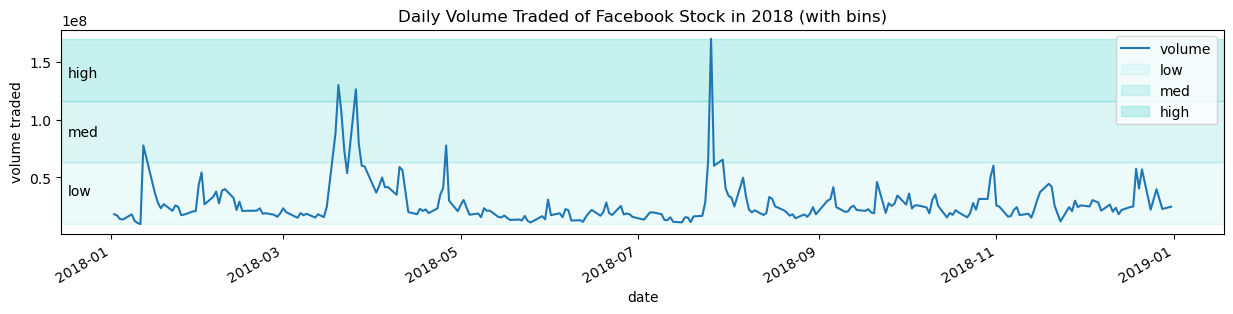

In [1078]:
fb.plot(y='volume', figsize=(15, 3), title='Daily Volume Traded of Facebook Stock in 2018 (with bins)')

for bin_name, alpha, bounds in zip(
    ['low', 'med', 'high'], [0.1, 0.2, 0.3], pd.cut(fb.volume, bins=3).unique().categories.values
):
    plt.axhspan(bounds.left, bounds.right, alpha=alpha, label=bin_name, color='mediumturquoise')
    plt.annotate(bin_name, xy=('2017-12-17', (bounds.left + bounds.right)/2.1))

plt.ylabel('volume traded')
plt.legend()
plt.show()

In [1080]:
volume_qbinned = pd.qcut(fb.volume, q=4, labels=['q1', 'q2', 'q3', 'q4'])
volume_qbinned.value_counts()

volume
q1    63
q2    63
q4    63
q3    62
Name: count, dtype: int64

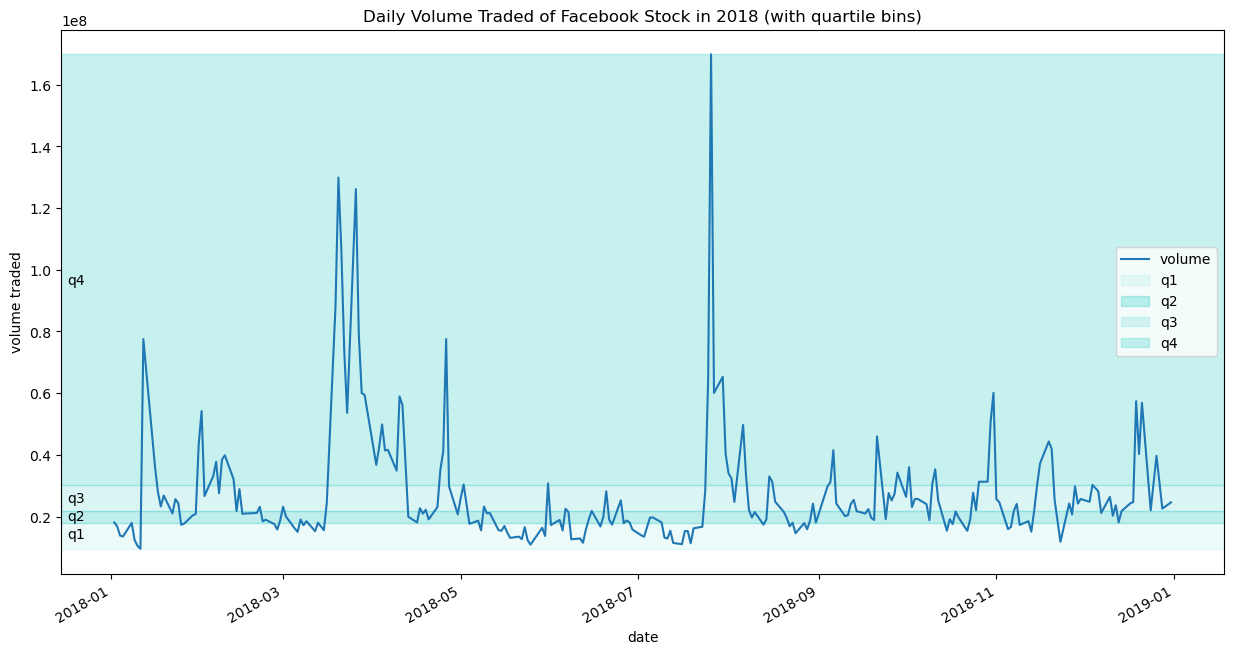

In [1082]:
fb.plot(y='volume', figsize=(15, 8), title='Daily Volume Traded of Facebook Stock in 2018 (with quartile bins)')

for bin_name, alpha, bounds in zip(
    ['q1', 'q2', 'q3', 'q4'], [0.1, 0.35, 0.2, 0.3], pd.qcut(fb.volume, q=4).unique().categories.values
):
    plt.axhspan(bounds.left, bounds.right, alpha=alpha, label=bin_name, color='mediumturquoise')
    plt.annotate(bin_name, xy=('2017-12-17', (bounds.left + bounds.right)/2.1))

plt.ylabel('volume traded')
plt.legend()
plt.show()


In [1088]:
central_park_weather = weather.query(
    'station == "GHCND:USW00094728"'
).pivot(index='date', columns='datatype', values='value')
central_park_weather.head()

datatype,ADPT,ASLP,ASTP,AWBT,AWND,PRCP,RHAV,RHMN,RHMX,SNOW,...,TMIN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT06,WT08
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,-194.0,10278.0,10224.0,-122.0,3.5,0.0,48.0,34.0,60.0,0.0,...,-13.8,300.0,300.0,6.7,11.2,NaN,NaN,NaN,NaN,NaN
2018-01-02,-156.0,10278.0,10227.0,-94.0,3.6,0.0,52.0,42.0,62.0,0.0,...,-10.5,260.0,250.0,7.2,12.5,NaN,NaN,NaN,NaN,NaN
2018-01-03,-161.0,10237.0,10196.0,-78.0,1.4,0.0,42.0,28.0,51.0,0.0,...,-8.8,260.0,270.0,6.3,9.8,NaN,NaN,NaN,NaN,NaN
2018-01-04,-94.0,9990.0,9925.0,-61.0,5.6,19.3,70.0,39.0,92.0,249.0,...,-7.1,310.0,310.0,10.7,19.2,1.0,1.0,NaN,NaN,1.0
2018-01-05,-206.0,10098.0,10030.0,-128.0,5.8,0.0,43.0,33.0,56.0,0.0,...,-12.7,280.0,280.0,9.4,15.7,NaN,NaN,NaN,NaN,NaN


In [1090]:
central_park_weather.SNOW.clip(0, 1).value_counts()

SNOW
0.0    348
1.0     11
Name: count, dtype: int64

In [1092]:
oct_weather_z_scores = central_park_weather.loc[
    '2018-10', ['TMIN', 'TMAX', 'PRCP']
].apply(lambda x: x.sub(x.mean()).div(x.std()))
oct_weather_z_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
datatype,,,,,,,,
TMIN,31.0,-1.790682e-16,1.0,-1.339112,-0.751019,-0.474269,1.065152,1.843511
TMAX,31.0,1.951844e-16,1.0,-1.305582,-0.870013,-0.138258,1.011643,1.604016
PRCP,31.0,1.038596e-16,1.0,-0.394438,-0.394438,-0.394438,-0.240253,3.936167


In [1094]:
oct_weather_z_scores.query('PRCP > 3')

datatype,TMIN,TMAX,PRCP
date,,,
2018-10-27,-0.751019,-1.201045,3.936167


In [1096]:
central_park_weather.loc['2018-10', 'PRCP'].describe()

count    31.000000
mean      2.941935
std       7.458542
min       0.000000
25%       0.000000
50%       0.000000
75%       1.150000
max      32.300000
Name: PRCP, dtype: float64

In [1098]:
import numpy as np
fb.apply(
    lambda x: np.vectorize(lambda y: len(str(np.ceil(y))))(x)
).astype('int64').equals(
    fb.applymap(lambda x: len(str(np.ceil(x))))
)

C:\Users\paala\AppData\Local\Temp\ipykernel_11428\3020784122.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  fb.applymap(lambda x: len(str(np.ceil(x))))


True

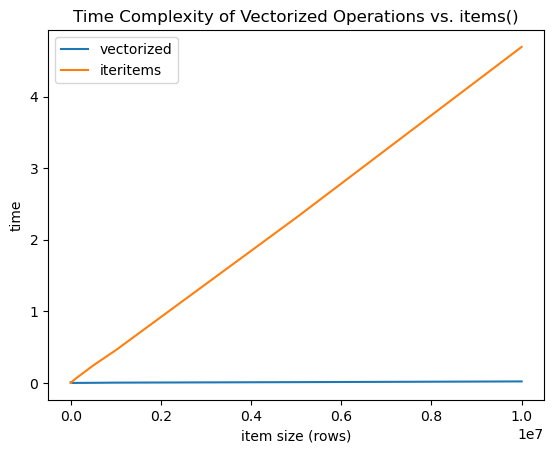

In [1108]:
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

np.random.seed(0)

vectorized_results = {}
iteritems_results = {}

for size in [10, 100, 1000, 10000, 100000, 500000, 1000000, 5000000, 10000000]:
    test = pd.Series(np.random.uniform(size=size))
    
    start = time.time()
    x = test + 10
    end = time.time()
    vectorized_results[size] = end - start
    start = time.time()
    x = []
    for i, v in test.items(): # iteritems is deprecated.
        x.append(v + 10)
    x = pd.Series(x)
    end = time.time()
    iteritems_results[size] = end - start

pd.DataFrame(
[pd.Series(vectorized_results, name='vectorized'), pd.Series(iteritems_results, name='iteritems')]
).T.plot(title='Time Complexity of Vectorized Operations vs. items()')

plt.xlabel('item size (rows)')
plt.ylabel('time')
plt.show()

In [1114]:
central_park_weather.loc['2018-10'].assign( # Use loc to locate the date given
    rolling_PRCP=lambda x: x.PRCP.rolling('3D').sum()
)[['PRCP', 'rolling_PRCP']].head(7).T

date,2018-10-01,2018-10-02,2018-10-03,2018-10-04,2018-10-05,2018-10-06,2018-10-07
datatype,,,,,,,
PRCP,0.0,17.5,0.0,1.0,0.0,0.0,0.0
rolling_PRCP,0.0,17.5,17.5,18.5,1.0,1.0,0.0


In [1118]:
central_park_weather.loc['2018-10'].rolling('3D').mean().head(7).iloc[:,:6] # Must use loc function to find the given date

datatype,ADPT,ASLP,ASTP,AWBT,AWND,PRCP
date,,,,,,
2018-10-01,172.000000,10247.000000,10200.000000,189.000000,0.900000,0.000000
2018-10-02,180.500000,10221.500000,10176.000000,194.500000,0.900000,8.750000
2018-10-03,172.333333,10205.333333,10159.000000,187.000000,0.966667,5.833333
2018-10-04,176.000000,10175.000000,10128.333333,187.000000,0.800000,6.166667
2018-10-05,155.666667,10177.333333,10128.333333,170.333333,1.033333,0.333333
2018-10-06,157.333333,10194.333333,10145.333333,170.333333,0.833333,0.333333
2018-10-07,163.000000,10217.000000,10165.666667,177.666667,1.066667,0.000000


In [1122]:
central_park_weather.loc['2018-10-01':'2018-10-07'].rolling('3D').agg( # Using loc again.
    {'TMAX': 'max', 'TMIN': 'min', 'AWND': 'mean', 'PRCP': 'sum'}
).join( # join with original data for comparison
    central_park_weather[['TMAX', 'TMIN', 'AWND', 'PRCP']],
    lsuffix='_rolling'
).sort_index(axis=1) # sort columns so rolling calcs are next to originals

datatype,AWND,AWND_rolling,PRCP,PRCP_rolling,TMAX,TMAX_rolling,TMIN,TMIN_rolling
date,,,,,,,,
2018-10-01,0.9,0.900000,0.0,0.0,24.4,24.4,17.2,17.2
2018-10-02,0.9,0.900000,17.5,17.5,25.0,25.0,18.3,17.2
2018-10-03,1.1,0.966667,0.0,17.5,23.3,25.0,17.2,17.2
2018-10-04,0.4,0.800000,1.0,18.5,24.4,25.0,16.1,16.1
2018-10-05,1.6,1.033333,0.0,1.0,21.7,24.4,15.6,15.6
2018-10-06,0.5,0.833333,0.0,1.0,20.0,24.4,17.2,15.6
2018-10-07,1.1,1.066667,0.0,0.0,26.1,26.1,19.4,15.6


In [1126]:
central_park_weather.PRCP.expanding().sum().equals(central_park_weather.PRCP.cumsum()) # They are unequal maybe because of the column values.

False

In [1128]:
fb.assign(
    close_ewma=lambda x: x.close.ewm(span=5).mean()
).tail(10)[['close', 'close_ewma']] # Ewma sounds really mean

,close,close_ewma
date,,
2018-12-17,140.19,142.235433
2018-12-18,143.66,142.710289
2018-12-19,133.24,139.553526
2018-12-20,133.40,137.502350
2018-12-21,124.95,133.318234
2018-12-24,124.06,130.232156
2018-12-26,134.18,131.548104
2018-12-27,134.52,132.538736
2018-12-28,133.20,132.759157


In [1136]:
def get_info(df):
    return '%d rows and %d columns and max closing z-score was %d' % (*df.shape, df.close.max())
fb.loc['2018-Q1'].apply(lambda x: (x - x.mean())/x.std()).pipe(get_info)\
    == get_info(fb.loc['2018-Q1'].apply(lambda x: (x - x.mean())/x.std())) # I will always keep in mind to use loc, when looking for specific values in the index.
                                                                        # It's weird. Perhaps the code snippets in this module were made long ago.

True

In [1138]:
fb.pipe(pd.DataFrame.rolling, '20D').mean().equals(fb.rolling('20D').mean())

True

In [1140]:
pd.DataFrame.rolling(fb, '20D').mean().equals(fb.rolling('20D').mean())

True

In [1170]:
from window_calc import window_calc
window_calc?? # What is this module library?
# I keep on looking for it but there is no records of it. Perhaps it's the Opticalc library?

SyntaxError: invalid syntax (1935717092.py, line 2)

In [1172]:
# Unfortunately, I could not load the window calculation library.
# Installing the package opticalc doesn't work too.

- 8.4 Aggregations

In [1176]:
import numpy as np
import pandas as pd

weather = pd.read_csv('C:/Users/paala/CPE311 - Paala/weather_by_station.csv', index_col='date', parse_dates=True)
weather.head()

,datatype,station,value,station_name
date,,,,
2018-01-01,PRCP,GHCND:US1CTFR0039,0.0,"STAMFORD 4.2 S, CT US"
2018-01-01,PRCP,GHCND:US1NJBG0015,0.0,"NORTH ARLINGTON 0.7 WNW, NJ US"
2018-01-01,SNOW,GHCND:US1NJBG0015,0.0,"NORTH ARLINGTON 0.7 WNW, NJ US"
2018-01-01,PRCP,GHCND:US1NJBG0017,0.0,"GLEN ROCK 0.7 SSE, NJ US"
2018-01-01,SNOW,GHCND:US1NJBG0017,0.0,"GLEN ROCK 0.7 SSE, NJ US"


In [1180]:
fb = pd.read_csv('C:/Users/paala/CPE311 - Paala/fb_2018.csv', index_col='date', parse_dates=True).assign(
    trading_volume=lambda x: pd.cut(x.volume, bins=3, labels=['low', 'med', 'high'])
)
fb.head()

,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02,177.68,181.58,177.5500,181.42,18151903,low
2018-01-03,181.88,184.78,181.3300,184.67,16886563,low
2018-01-04,184.90,186.21,184.0996,184.33,13880896,low
2018-01-05,185.59,186.90,184.9300,186.85,13574535,low
2018-01-08,187.20,188.90,186.3300,188.28,17994726,low


In [1182]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [1186]:
fb.agg({
    'open': 'mean',
    'high': 'max',
    'low': 'min',
    'close': 'mean',
    'volume': 'sum'

})

open            171.45
high            218.62
low             123.02
close           171.51
volume   6949682394.00
dtype: float64

In [1188]:
weather.query(
    'station == "GHCND:USW00094728"'
).pivot(columns='datatype', values='value')[['SNOW', 'PRCP']].sum()

datatype
SNOW   1007.00
PRCP   1665.30
dtype: float64

In [1190]:
weather.query(
    'station == "GHCND:USW00094728"'
).pivot(columns='datatype', values='value')[['SNOW', 'PRCP']].agg('sum')

datatype
SNOW   1007.00
PRCP   1665.30
dtype: float64

In [1192]:
fb.agg({
    'open': 'mean',
    'high': ['min', 'max'],
    'low': ['min', 'max'],
    'close':'mean'
})


,open,high,low,close
mean,171.45,NaN,NaN,171.51
min,NaN,129.74,123.02,NaN
max,NaN,218.62,214.27,NaN


In [1200]:
fb.groupby('trading_volume', observed=True).mean() # Observed = True because the default False is going to be deprecated. It's a good practice to get used to it.

,open,high,low,close,volume
trading_volume,,,,,
low,171.36,173.46,169.31,171.43,24547207.71
med,175.82,179.42,172.11,175.14,79072559.12
high,167.73,170.48,161.57,168.16,141924023.33


In [1204]:
fb.groupby('trading_volume', observed=True)['close'].agg(['min', 'max', 'mean'])

,min,max,mean
trading_volume,,,
low,124.06,214.67,171.43
med,152.22,217.50,175.14
high,160.06,176.26,168.16


In [1220]:
fb_agg = fb.groupby('trading_volume', observed=True).agg({
    'open': 'mean',
    'high': ['min', 'max'],
    'low': ['min', 'max'],
    'close': 'mean'
})
fb_agg

open   high           low         close
                 mean    min    max    min    max   mean
trading_volume                                          
low            171.36 129.74 216.20 123.02 212.60 171.43
med            175.82 162.85 218.62 150.75 214.27 175.14
high           167.73 161.10 180.13 149.02 173.75 168.16

In [1222]:
fb_agg.columns # The hierarchical index is now properly arranged

MultiIndex([( 'open', 'mean'),
            ( 'high',  'min'),
            ( 'high',  'max'),
            (  'low',  'min'),
            (  'low',  'max'),
            ('close', 'mean')],
           )

In [1224]:
fb_agg.columns = ['_'.join(col_agg) for col_agg in fb_agg.columns]
fb_agg.head()

,open_mean,high_min,high_max,low_min,low_max,close_mean
trading_volume,,,,,,
low,171.36,129.74,216.20,123.02,212.60,171.43
med,175.82,162.85,218.62,150.75,214.27,175.14
high,167.73,161.10,180.13,149.02,173.75,168.16


In [1248]:
weather.loc['2018-10'].query('datatype == "PRCP"').groupby(
    pd.Grouper(freq='D')
)['value'].mean().head() # The value was added because aggregate function only uses the non-numerical values

date
2018-10-01    0.01
2018-10-02    2.23
2018-10-03   19.69
2018-10-04    0.32
2018-10-05    0.97
Freq: D, Name: value, dtype: float64

In [1254]:
weather.query('datatype == "PRCP"').groupby(
    ['station_name', pd.Grouper(freq='QE')] # Use QE instead
)['value'].sum().unstack().sample(5, random_state=1) # Like before, the datatype itself is being aggregated too. That is why we need to focus on the numerical values only.


date,2018-03-31,2018-06-30,2018-09-30,2018-12-31
station_name,,,,
"WANTAGH 1.1 NNE, NY US",279.90,216.80,472.50,277.20
"STATEN ISLAND 1.4 SE, NY US",379.40,295.30,438.80,409.90
"SYOSSET 2.0 SSW, NY US",323.50,263.30,355.50,459.90
"STAMFORD 4.2 S, CT US",338.00,272.10,424.70,390.00
"WAYNE TWP 0.8 SSW, NJ US",246.20,295.30,620.90,422.00


In [1258]:
weather.groupby('station').filter( # station IDs with NY in them
    lambda x: 'NY' in x.name
).query('datatype == "SNOW"').groupby('station_name')['value'].sum().squeeze() # aggregate and make a series (squeeze)

station_name
ALBERTSON 0.2 SSE, NY US         1087.00
AMITYVILLE 0.1 WSW, NY US         434.00
AMITYVILLE 0.6 NNE, NY US        1072.00
ARMONK 0.3 SE, NY US             1504.00
BROOKLYN 3.1 NW, NY US            305.00
CENTERPORT 0.9 SW, NY US          799.00
ELMSFORD 0.8 SSW, NY US           863.00
FLORAL PARK 0.4 W, NY US         1015.00
HICKSVILLE 1.3 ENE, NY US         716.00
JACKSON HEIGHTS 0.3 WSW, NY US    107.00
LOCUST VALLEY 0.3 E, NY US          0.00
LYNBROOK 0.3 NW, NY US            325.00
MASSAPEQUA 0.9 SSW, NY US          41.00
MIDDLE VILLAGE 0.5 SW, NY US     1249.00
NEW HYDE PARK 1.6 NE, NY US         0.00
NEW YORK 8.8 N, NY US               0.00
NORTH WANTAGH 0.4 WSW, NY US      471.00
PLAINEDGE 0.4 WSW, NY US          610.00
PLAINVIEW 0.4 ENE, NY US         1360.00
SADDLE ROCK 3.4 WSW, NY US        707.00
STATEN ISLAND 1.4 SE, NY US       936.00
STATEN ISLAND 4.5 SSE, NY US       89.00
SYOSSET 2.0 SSW, NY US           1039.00
VALLEY STREAM 0.6 SE, NY US       898.00
WAN

In [1292]:
weather.query('datatype == "PRCP"') \
    .groupby(pd.Grouper(freq='D'))['value'].mean() \
    .groupby(pd.Grouper(freq='ME')).sum() \
    .nlargest(5) # Stating the value column is important. Never forget.

date
2018-11-30   210.59
2018-09-30   193.09
2018-08-31   192.45
2018-07-31   160.98
2018-02-28   158.11
Name: value, dtype: float64

In [1298]:
weather.query('datatype == "PRCP"') \
    .rename(dict(value='prcp'), axis=1) \
    .groupby(pd.Grouper(freq='D'))['prcp'].mean() \
    .groupby(pd.Grouper(freq='ME')) \
    .transform(np.sum).loc['2018-01-28':'2018-02-03']

C:\Users\paala\AppData\Local\Temp\ipykernel_11428\1722832457.py:5: FutureWarning: The provided callable <function sum at 0x0000014513E06700> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .transform(np.sum).loc['2018-01-28':'2018-02-03']


date
2018-01-28    69.31
2018-01-29    69.31
2018-01-30    69.31
2018-01-31    69.31
2018-02-01   158.11
2018-02-02   158.11
2018-02-03   158.11
Freq: D, Name: prcp, dtype: float64

In [1313]:
weather\
    .query('datatype == "PRCP"')\
    .rename(dict(value='prcp'), axis=1)\
    .groupby(pd.Grouper(freq='D'))['prcp'].mean() \
    .to_frame()\
    .assign(
        total_prcp_in_month=lambda x: x.groupby(
            pd.Grouper(freq='ME')
        ).transform('sum'),
        pct_monthly_prcp=lambda x: x.prcp.div(
            x.total_prcp_in_month
        )
    ).nlargest(5, 'pct_monthly_prcp')
# To_frame was added to put back the series into a DataFrame.

,prcp,total_prcp_in_month,pct_monthly_prcp
date,,,
2018-10-12,34.77,105.63,0.33
2018-01-13,21.66,69.31,0.31
2018-03-02,38.77,137.46,0.28
2018-04-16,39.34,140.57,0.28
2018-04-17,37.30,140.57,0.27


In [1315]:
fb[['open', 'high', 'low', 'close']].transform(
    lambda x: (x - x.mean()).div(x.std())
).head()

,open,high,low,close
date,,,,
2018-01-02,0.32,0.41,0.41,0.50
2018-01-03,0.53,0.57,0.60,0.66
2018-01-04,0.68,0.65,0.74,0.64
2018-01-05,0.72,0.68,0.78,0.77
2018-01-08,0.80,0.79,0.85,0.84


In [1319]:
fb.pivot_table(columns='trading_volume', observed=True)

trading_volume,low,med,high
close,171.43,175.14,168.16
high,173.46,179.42,170.48
low,169.31,172.11,161.57
open,171.36,175.82,167.73
volume,24547207.71,79072559.12,141924023.33


In [1321]:
fb.pivot_table(index='trading_volume', observed=True)

,close,high,low,open,volume
trading_volume,,,,,
low,171.43,173.46,169.31,171.36,24547207.71
med,175.14,179.42,172.11,175.82,79072559.12
high,168.16,170.48,161.57,167.73,141924023.33


In [1323]:
weather.reset_index().pivot_table(
    index=['date', 'station', 'station_name'],
    columns='datatype',
    values='value',
    aggfunc='median'
).reset_index().tail()


datatype,date,station,station_name,AWND,DAPR,MDPR,PGTM,PRCP,SNOW,SNWD,...,WSF5,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,WT11
28740,2018-12-31,GHCND:USW00054787,"FARMINGDALE REPUBLIC AIRPORT, NY US",5.00,NaN,NaN,2052.00,28.70,NaN,NaN,...,15.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28741,2018-12-31,GHCND:USW00094728,"NY CITY CENTRAL PARK, NY US",NaN,NaN,NaN,NaN,25.90,0.00,0.00,...,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28742,2018-12-31,GHCND:USW00094741,"TETERBORO AIRPORT, NJ US",1.70,NaN,NaN,1954.00,29.20,NaN,NaN,...,8.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28743,2018-12-31,GHCND:USW00094745,"WESTCHESTER CO AIRPORT, NY US",2.70,NaN,NaN,2212.00,24.40,NaN,NaN,...,11.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28744,2018-12-31,GHCND:USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",4.10,NaN,NaN,NaN,31.20,0.00,0.00,...,12.50,1.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1325]:
pd.crosstab(
    index=fb.trading_volume,
    columns=fb.index.month,
    colnames=['month'] # name the columns index
)

month,1,2,3,4,5,6,7,8,9,10,11,12
trading_volume,,,,,,,,,,,,
low,20,19,15,20,22,21,18,23,19,23,21,19
med,1,0,4,1,0,0,2,0,0,0,0,0
high,0,0,2,0,0,0,1,0,0,0,0,0


In [1327]:
pd.crosstab(
    index=fb.trading_volume,
    columns=fb.index.month,
    colnames=['month'],
    normalize='columns'
)

month,1,2,3,4,5,6,7,8,9,10,11,12
trading_volume,,,,,,,,,,,,
low,0.95,1.00,0.71,0.95,1.00,1.00,0.86,1.00,1.00,1.00,1.00,1.00
med,0.05,0.00,0.19,0.05,0.00,0.00,0.10,0.00,0.00,0.00,0.00,0.00
high,0.00,0.00,0.10,0.00,0.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00


In [1333]:
pd.crosstab(
    index=fb.trading_volume,
    columns=fb.index.month,
    colnames=['month'],
    values=fb.close,
    aggfunc='mean')


month,1,2,3,4,5,6,7,8,9,10,11,12
trading_volume,,,,,,,,,,,,
low,185.24,180.27,177.07,163.29,182.93,195.27,201.92,177.49,164.38,154.19,141.64,137.16
med,179.37,NaN,164.76,174.16,NaN,NaN,194.28,NaN,NaN,NaN,NaN,NaN
high,NaN,NaN,164.11,NaN,NaN,NaN,176.26,NaN,NaN,NaN,NaN,NaN


In [1335]:
snow_data = weather.query('datatype == "SNOW"')
pd.crosstab(
    index=snow_data.station_name,
    columns=snow_data.index.month,
    colnames=['month'],
    values=snow_data.value,
    aggfunc=lambda x: (x > 0).sum(),
    margins=True, # show row and column subtotals
    margins_name='total observations of snow' # name the subtotals
)


month,1,2,3,4,5,6,7,8,9,10,11,12,total observations of snow
station_name,,,,,,,,,,,,,
"ALBERTSON 0.2 SSE, NY US",3.00,1.00,3.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,9
"AMITYVILLE 0.1 WSW, NY US",1.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3
"AMITYVILLE 0.6 NNE, NY US",3.00,1.00,3.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8
"ARMONK 0.3 SE, NY US",6.00,4.00,6.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,3.00,23
"BLOOMINGDALE 0.7 SSE, NJ US",2.00,1.00,3.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"WESTFIELD 0.6 NE, NJ US",3.00,0.00,4.00,1.00,0.00,NaN,0.00,0.00,0.00,NaN,1.00,NaN,9
"WOODBRIDGE TWP 1.1 ESE, NJ US",4.00,1.00,3.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,11
"WOODBRIDGE TWP 1.1 NNE, NJ US",2.00,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,7


- 8.5 Time Series

In [1338]:
import numpy as np
import pandas as pd
fb = pd.read_csv('C:/Users/paala/CPE311 - Paala/fb_2018.csv', index_col='date', parse_dates=True).assign(
    trading_volume=lambda x: pd.cut(x.volume, bins=3, labels=['low', 'med', 'high'])
)
fb.head()

,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02,177.68,181.58,177.55,181.42,18151903,low
2018-01-03,181.88,184.78,181.33,184.67,16886563,low
2018-01-04,184.90,186.21,184.10,184.33,13880896,low
2018-01-05,185.59,186.90,184.93,186.85,13574535,low
2018-01-08,187.20,188.90,186.33,188.28,17994726,low


In [1340]:
fb['2018-10-11':'2018-10-15']

,open,high,low,close,volume,trading_volume
date,,,,,,
2018-10-11,150.13,154.81,149.16,153.35,35338901,low
2018-10-12,156.73,156.89,151.30,153.74,25293492,low
2018-10-15,153.32,155.57,152.55,153.52,15433521,low


In [1344]:
fb.loc['2018-q1'].equals(fb['2018-01':'2018-03'])

True

In [1350]:
fb.first('1W')

C:\Users\paala\AppData\Local\Temp\ipykernel_11428\2655357208.py:1: FutureWarning: first is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  fb.first('1W')


,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02,177.68,181.58,177.55,181.42,18151903,low
2018-01-03,181.88,184.78,181.33,184.67,16886563,low
2018-01-04,184.90,186.21,184.10,184.33,13880896,low
2018-01-05,185.59,186.90,184.93,186.85,13574535,low


In [1352]:
fb.last('1W')

C:\Users\paala\AppData\Local\Temp\ipykernel_11428\2477606097.py:1: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  fb.last('1W')


,open,high,low,close,volume,trading_volume
date,,,,,,
2018-12-31,134.45,134.64,129.95,131.09,24625308,low


In [1370]:
stock_data_per_minute = pd.read_csv(
'C:/Users/paala/CPE311 - Paala/fb_week_of_may_20_per_minute.csv', index_col='date', parse_dates=True,
date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d %H-%M')
)
stock_data_per_minute.head()

C:\Users\paala\AppData\Local\Temp\ipykernel_11428\3128433989.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  stock_data_per_minute = pd.read_csv(


,open,high,low,close,volume
date,,,,,
2019-05-20 09:30:00,181.62,181.62,181.62,181.62,159049.00
2019-05-20 09:31:00,182.61,182.61,182.61,182.61,468017.00
2019-05-20 09:32:00,182.75,182.75,182.75,182.75,97258.00
2019-05-20 09:33:00,182.95,182.95,182.95,182.95,43961.00
2019-05-20 09:34:00,183.06,183.06,183.06,183.06,79562.00


In [1372]:
stock_data_per_minute.groupby(pd.Grouper(freq='1D')).agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
})

,open,high,low,close,volume
date,,,,,
2019-05-20,181.62,184.18,181.62,182.72,10044838.00
2019-05-21,184.53,185.58,183.97,184.82,7198405.00
2019-05-22,184.81,186.56,184.01,185.32,8412433.00
2019-05-23,182.50,183.73,179.76,180.87,12479171.00
2019-05-24,182.33,183.52,181.04,181.06,7686030.00


In [1374]:
stock_data_per_minute.at_time('9:30')

,open,high,low,close,volume
date,,,,,
2019-05-20 09:30:00,181.62,181.62,181.62,181.62,159049.00
2019-05-21 09:30:00,184.53,184.53,184.53,184.53,58171.00
2019-05-22 09:30:00,184.81,184.81,184.81,184.81,41585.00
2019-05-23 09:30:00,182.50,182.50,182.50,182.50,121930.00
2019-05-24 09:30:00,182.33,182.33,182.33,182.33,52681.00


In [1376]:
stock_data_per_minute.between_time('15:59', '16:00')


,open,high,low,close,volume
date,,,,,
2019-05-20 15:59:00,182.91,182.91,182.91,182.91,134569.00
2019-05-20 16:00:00,182.72,182.72,182.72,182.72,1113672.00
2019-05-21 15:59:00,184.84,184.84,184.84,184.84,61606.00
2019-05-21 16:00:00,184.82,184.82,184.82,184.82,801080.00
2019-05-22 15:59:00,185.29,185.29,185.29,185.29,96099.00
2019-05-22 16:00:00,185.32,185.32,185.32,185.32,1220993.00
2019-05-23 15:59:00,180.72,180.72,180.72,180.72,109648.00
2019-05-23 16:00:00,180.87,180.87,180.87,180.87,1329217.00
2019-05-24 15:59:00,181.07,181.07,181.07,181.07,52994.00


In [1378]:
shares_traded_in_first_30_min = stock_data_per_minute\
    .between_time('9:30', '10:00')\
    .groupby(pd.Grouper(freq='1D'))\
    .filter(lambda x: (x.volume > 0).all())\
    .volume.mean()

shares_traded_in_last_30_min = stock_data_per_minute\
    .between_time('15:30', '16:00')\
    .groupby(pd.Grouper(freq='1D'))\
    .filter(lambda x: (x.volume > 0).all())\
    .volume.mean()

shares_traded_in_first_30_min - shares_traded_in_last_30_min

18592.967741935485

In [1380]:
pd.DataFrame(
    dict(before=stock_data_per_minute.index, after=stock_data_per_minute.index.normalize())
).head()

,before,after
0,2019-05-20 09:30:00,2019-05-20
1,2019-05-20 09:31:00,2019-05-20
2,2019-05-20 09:32:00,2019-05-20
3,2019-05-20 09:33:00,2019-05-20
4,2019-05-20 09:34:00,2019-05-20


In [1382]:
stock_data_per_minute.index.to_series().dt.normalize().head()

date
2019-05-20 09:30:00   2019-05-20
2019-05-20 09:31:00   2019-05-20
2019-05-20 09:32:00   2019-05-20
2019-05-20 09:33:00   2019-05-20
2019-05-20 09:34:00   2019-05-20
Name: date, dtype: datetime64[ns]

In [1384]:
fb.assign(
    prior_close=lambda x: x.close.shift(),
    after_hours_change_in_price=lambda x: x.open - x.prior_close,
    abs_change=lambda x: x.after_hours_change_in_price.abs()
).nlargest(5, 'abs_change')


,open,high,low,close,volume,trading_volume,prior_close,after_hours_change_in_price,abs_change
date,,,,,,,,,
2018-07-26,174.89,180.13,173.75,176.26,169803668,high,217.50,-42.61,42.61
2018-04-26,173.22,176.27,170.80,174.16,77556934,med,159.69,13.53,13.53
2018-01-12,178.06,181.48,177.40,179.37,77551299,med,187.77,-9.71,9.71
2018-10-31,155.00,156.40,148.96,151.79,60101251,low,146.22,8.78,8.78
2018-03-19,177.01,177.17,170.06,172.56,88140060,med,185.09,-8.08,8.08


In [1386]:
pd.date_range('2018-01-01', freq='D', periods=5) + pd.Timedelta('9 hours 30 minutes')

DatetimeIndex(['2018-01-01 09:30:00', '2018-01-02 09:30:00',
               '2018-01-03 09:30:00', '2018-01-04 09:30:00',
               '2018-01-05 09:30:00'],
              dtype='datetime64[ns]', freq='D')

In [1390]:
fb.loc['2018-09'].first_valid_index()

Timestamp('2018-09-04 00:00:00')

In [1392]:
fb.loc['2018-09'].last_valid_index()

Timestamp('2018-09-28 00:00:00')

In [1400]:
# fb.index.contains('2018-09-30')
# There are no contains attribute in the index function.
pd.Timestamp('2018-09-30') in fb.index

False

In [1402]:
fb.asof('2018-09-30')

open                168.33
high                168.79
low                 162.56
close               164.46
volume            34265638
trading_volume         low
Name: 2018-09-30 00:00:00, dtype: object

In [1404]:
(
    fb.drop(columns='trading_volume')
    - fb.drop(columns='trading_volume').shift()
).equals(
    fb.drop(columns='trading_volume').diff()
)

True

In [1406]:
fb.drop(columns='trading_volume').diff().head()


,open,high,low,close,volume
date,,,,,
2018-01-02,NaN,NaN,NaN,NaN,NaN
2018-01-03,4.20,3.20,3.78,3.25,-1265340.00
2018-01-04,3.02,1.43,2.77,-0.34,-3005667.00
2018-01-05,0.69,0.69,0.83,2.52,-306361.00
2018-01-08,1.61,2.00,1.40,1.43,4420191.00


In [1408]:
fb.drop(columns='trading_volume').diff(-3).head()

,open,high,low,close,volume
date,,,,,
2018-01-02,-7.91,-5.32,-7.38,-5.43,4577368.00
2018-01-03,-5.32,-4.12,-5.00,-3.61,-1108163.00
2018-01-04,-3.80,-2.59,-3.00,-3.54,1487839.00
2018-01-05,-1.35,-0.99,-0.70,-0.99,3044641.00
2018-01-08,-1.20,0.50,-1.05,0.51,8406139.00


In [1410]:
import matplotlib.pyplot as plt

C:\Users\paala\AppData\Local\Temp\ipykernel_11428\3462238832.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  index = pd.date_range('2018-01-01', freq='T', periods=365*24*60)


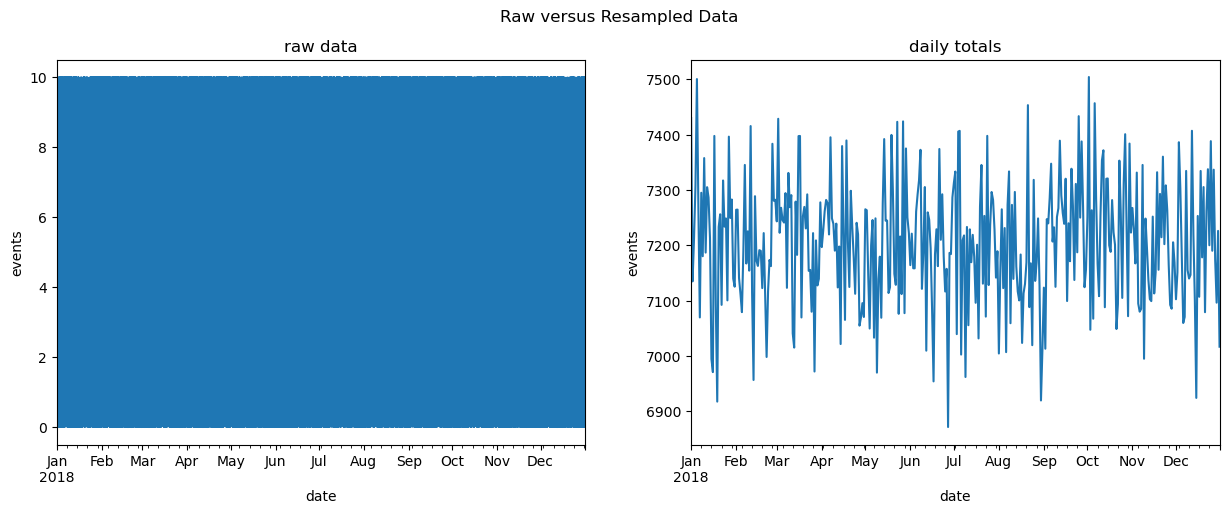

In [1416]:
index = pd.date_range('2018-01-01', freq='T', periods=365*24*60)
raw = pd.DataFrame(
    np.random.uniform(0, 10, size=index.shape[0]), index=index
)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
raw.plot(legend=False, ax=axes[0], title='raw data')
raw.resample('1D').sum().plot(legend=False, ax=axes[1], title='daily totals')
for ax in axes:
    ax.set_xlabel('date')
    ax.set_ylabel('events')
plt.suptitle('Raw versus Resampled Data')
plt.show() # It took a minute to load!

In [1417]:
stock_data_per_minute.head()

,open,high,low,close,volume
date,,,,,
2019-05-20 09:30:00,181.62,181.62,181.62,181.62,159049.00
2019-05-20 09:31:00,182.61,182.61,182.61,182.61,468017.00
2019-05-20 09:32:00,182.75,182.75,182.75,182.75,97258.00
2019-05-20 09:33:00,182.95,182.95,182.95,182.95,43961.00
2019-05-20 09:34:00,183.06,183.06,183.06,183.06,79562.00


In [1418]:
stock_data_per_minute.resample('1D').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
})

,open,high,low,close,volume
date,,,,,
2019-05-20,181.62,184.18,181.62,182.72,10044838.00
2019-05-21,184.53,185.58,183.97,184.82,7198405.00
2019-05-22,184.81,186.56,184.01,185.32,8412433.00
2019-05-23,182.50,183.73,179.76,180.87,12479171.00
2019-05-24,182.33,183.52,181.04,181.06,7686030.00


In [1440]:
fb.resample('QE').mean(numeric_only=True) # The argument tells the function that it will only get the numerical values from the index.

,open,high,low,close,volume
date,,,,,
2018-03-31,179.47,181.79,177.04,179.55,32926396.70
2018-06-30,180.37,182.28,178.60,180.70,24055317.75
2018-09-30,180.81,182.89,178.96,181.03,27019824.76
2018-12-31,145.27,147.62,142.72,144.87,26974331.73


In [1426]:
fb.drop(columns='trading_volume').resample('Q').apply(
    lambda x: x.last('1D').values - x.first('1D').values
)

C:\Users\paala\AppData\Local\Temp\ipykernel_11428\816813945.py:1: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  fb.drop(columns='trading_volume').resample('Q').apply(
C:\Users\paala\AppData\Local\Temp\ipykernel_11428\816813945.py:2: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  lambda x: x.last('1D').values - x.first('1D').values
C:\Users\paala\AppData\Local\Temp\ipykernel_11428\816813945.py:2: FutureWarning: first is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  lambda x: x.last('1D').values - x.first('1D').values
C:\Users\paala\AppData\Local\Temp\ipykernel_11428\816813945.py:2: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  lambda x: x.last('1D').values - x.first('1D').values
C:\Users\paala\AppData\Local\T

date
2018-03-31    [[-22.53, -20.160000000000025, -23.41000000000...
2018-06-30    [[39.50999999999999, 38.399700000000024, 39.84...
2018-09-30    [[-25.039999999999992, -28.659999999999997, -2...
2018-12-31    [[-28.580000000000013, -31.24000000000001, -31...
Freq: QE-DEC, dtype: object

In [1434]:
melted_stock_data = pd.read_csv('C:/Users/paala/CPE311 - Paala/melted_stock_data.csv', index_col='date', parse_dates=True)
melted_stock_data.head()

,price
date,
2019-05-20 09:30:00,181.62
2019-05-20 09:31:00,182.61
2019-05-20 09:32:00,182.75
2019-05-20 09:33:00,182.95
2019-05-20 09:34:00,183.06


In [1442]:
melted_stock_data.resample('1D').ohlc()['price']

,open,high,low,close
date,,,,
2019-05-20,181.62,184.18,181.62,182.72
2019-05-21,184.53,185.58,183.97,184.82
2019-05-22,184.81,186.56,184.01,185.32
2019-05-23,182.50,183.73,179.76,180.87
2019-05-24,182.33,183.52,181.04,181.06


In [1446]:
fb.resample('6h').asfreq().head()

,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02 00:00:00,177.68,181.58,177.55,181.42,18151903.00,low
2018-01-02 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03 00:00:00,181.88,184.78,181.33,184.67,16886563.00,low


In [1452]:
# fb.resample('6h').pad().head() The pad function has deprecated ages ago. The modernized version would be ffill().
fb.resample('6h').ffill().head()

,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02 00:00:00,177.68,181.58,177.55,181.42,18151903,low
2018-01-02 06:00:00,177.68,181.58,177.55,181.42,18151903,low
2018-01-02 12:00:00,177.68,181.58,177.55,181.42,18151903,low
2018-01-02 18:00:00,177.68,181.58,177.55,181.42,18151903,low
2018-01-03 00:00:00,181.88,184.78,181.33,184.67,16886563,low


In [1454]:
fb.resample('6h').fillna('nearest').head()

C:\Users\paala\AppData\Local\Temp\ipykernel_11428\1185989255.py:1: FutureWarning: DatetimeIndexResampler.fillna is deprecated and will be removed in a future version. Use obj.ffill(), obj.bfill(), or obj.nearest() instead.
  fb.resample('6h').fillna('nearest').head()


,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02 00:00:00,177.68,181.58,177.55,181.42,18151903,low
2018-01-02 06:00:00,177.68,181.58,177.55,181.42,18151903,low
2018-01-02 12:00:00,181.88,184.78,181.33,184.67,16886563,low
2018-01-02 18:00:00,181.88,184.78,181.33,184.67,16886563,low
2018-01-03 00:00:00,181.88,184.78,181.33,184.67,16886563,low


In [1462]:
fb.resample('6h').asfreq().assign(
    volume=lambda x: x.volume.fillna(0), # put 0 when market is closed
    close=lambda x: x.close.ffill(), # carry forward
    # replace the fillna(method) argument into ffill() instead.
    # take the closing price if these aren't available
    open=lambda x: np.where(x.open.isnull(), x.close, x.open),
    high=lambda x: np.where(x.high.isnull(), x.close, x.high),
    low=lambda x: np.where(x.low.isnull(), x.close, x.low)
).head()

,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02 00:00:00,177.68,181.58,177.55,181.42,18151903.00,low
2018-01-02 06:00:00,181.42,181.42,181.42,181.42,0.00,NaN
2018-01-02 12:00:00,181.42,181.42,181.42,181.42,0.00,NaN
2018-01-02 18:00:00,181.42,181.42,181.42,181.42,0.00,NaN
2018-01-03 00:00:00,181.88,184.78,181.33,184.67,16886563.00,low


In [1466]:
import sqlite3
with sqlite3.connect('C:/Users/paala/CPE311 - Paala/stocks.db') as connection:
    fb_prices = pd.read_sql(
        'SELECT * FROM fb_prices', connection,
        index_col='date', parse_dates=['date']
)
    aapl_prices = pd.read_sql(
        'SELECT * FROM aapl_prices', connection,
        index_col='date', parse_dates=['date']
)

In [1468]:
fb_prices.index.second.unique()

Index([0], dtype='int32', name='date')

In [1470]:
aapl_prices.index.second.unique()

Index([ 0, 52, 36, 34, 55, 35,  7, 12, 59, 17,  5, 20, 26, 23, 54, 49, 19, 53,
       11, 22, 13, 21, 10, 46, 42, 38, 33, 18, 16,  9, 56, 39,  2, 50, 31, 58,
       48, 24, 29,  6, 47, 51, 40,  3, 15, 14, 25,  4, 43,  8, 32, 27, 30, 45,
        1, 44, 57, 41, 37, 28],
      dtype='int32', name='date')

In [1474]:
pd.merge_asof(
    fb_prices, aapl_prices,
    left_index=True, right_index=True, # datetimes are in the index
    # merge with nearest minute
    direction='nearest', tolerance=pd.Timedelta(30, unit='s')
).head()

,FB,AAPL
date,,
2019-05-20 09:30:00,181.62,183.52
2019-05-20 09:31:00,182.61,NaN
2019-05-20 09:32:00,182.75,182.87
2019-05-20 09:33:00,182.95,182.50
2019-05-20 09:34:00,183.06,182.11


In [1476]:
pd.merge_ordered(
    fb_prices.reset_index(), aapl_prices.reset_index()
).set_index('date').head()

,FB,AAPL
date,,
2019-05-20 09:30:00,181.62,183.52
2019-05-20 09:31:00,182.61,NaN
2019-05-20 09:31:52,NaN,182.87
2019-05-20 09:32:00,182.75,NaN
2019-05-20 09:32:36,NaN,182.50


In [1478]:
pd.merge_ordered(
    fb_prices.reset_index(), aapl_prices.reset_index(),
    fill_method='ffill'
).set_index('date').head()

,FB,AAPL
date,,
2019-05-20 09:30:00,181.62,183.52
2019-05-20 09:31:00,182.61,183.52
2019-05-20 09:31:52,182.61,182.87
2019-05-20 09:32:00,182.75,182.87
2019-05-20 09:32:36,182.75,182.50


**8.1.4 Data Analysis**

Provide some comments here about the results of the procedures.

*It was quite exhausting to understand because it is too overwhelming to comprehend, however, I found that there are data which takes forever to load, like filling columns using the date in making requests for getting values for the columns. There are many of the code snippets where there are deprecated functions, and I decided to change some of it. There are also libaries that I was not able to load, because I wanted to focus in completing all of the procedures. There were many things that I understood, like the importance of using the loc function in datetime indices. Because some of the code snippets in the procedures don't have loc functions. The values of the series also matter, that is why I won't forget to put the ['value'] in each time I aggregate and grouping by. There was so many data that my soul is about to get sucked out of planet Earth. However, I think this is good. It is a good practice or mindset because, it's just one activity. What more if it is in real life, right?*

**8.1.5 Supplementary Activity**

Using the CSV files provided and what we have learned so far in this module complete the following exercises:

1. With the earthquakes.csv file, select all the earthquakes in Japan with a magType of mb and a magnitude of 4.9 or greater.

In [269]:
import pandas as pd

df_eq = pd.read_csv('C:/Users/paala/CPE311 - Paala/earthquakes.csv')
""" Loading the CSV file through pandas
    Then, use the query to filter the following conditions.
    """
df_eq_query = df_eq.query("mag > 4.9 and magType == 'mb'") # first condition
df_eq_japan = df_eq_query.query("parsed_place == 'Japan'") # second condition

In [271]:
df_eq_query.head()

,mag,magType,time,place,tsunami,parsed_place
227,5.2,mb,1539389603790,"15km WSW of Pisco, Peru",0,Peru
258,5.1,mb,1539380306940,"236km NNW of Kuril'sk, Russia",0,Russia
391,5.1,mb,1539337221080,Pacific-Antarctic Ridge,0,Pacific-Antarctic Ridge
623,5.1,mb,1539270492120,"162km S of Severo-Kuril'sk, Russia",0,Russia
719,5.2,mb,1539236855840,"163km S of Severo-Kuril'sk, Russia",0,Russia


In [273]:
df_eq_japan.head()

,mag,magType,time,place,tsunami,parsed_place
2576,5.4,mb,1538697528010,"37km E of Tomakomai, Japan",0,Japan


2. Create bins for each full number of magnitude (for example, the first bin is 0-1, the second is 1-2, and so on) with a magType of ml and count how many are in each bin.

In [291]:
import numpy as np # importing the numpy library for the functions that rounds up and down.

def bins(df):
    query = df.query("magType == 'ml' and mag >= 0") # Filters ml magtype and magnitudes that are greater than 0 (to prevent negative values in the bin key.)
    min_query = int(np.floor(query['mag'].min())) # Round down to the nearest integer.
    max_query = int(np.ceil(query['mag'].max())) # Round up to the nearest integer.
    bins = list(range(min_query, max_query+1)) # Stores the integers in a list.
    counts = {f"{i}-{i+1}": 0 for i in bins[:-1]} # Save the bins in a dictionary
    for index, row in query.loc[:, ['mag']].iterrows(): # A for loop for finding each rows in the mag columns.
        if row['mag'] < 0: # If the magnitude is negative, proceed to the next index.
            continue
        for i in bins[:-1]: # for each index in the minimum and maximum magnitude
            if i <= row['mag'] <= i+1: # A condition that filters the magnitude in the dataframe
                counts[f"{i}-{i+1}"] += 1 # Updates the dictionary with counts
                break
    for keys, values in counts.items(): # Print results in each bins.
        if values > 1:
            print(f'There are a total of {values} entries in the {keys} bin.')
        else:
            print (f'There are a total of {values} entry in the {keys} bin.')


# Applying OOP in the querying Dataframes, since it is possible to just create a function that will
# apply queries in each bin by the use of for loops rather than manually creating each bin.
# It was a pain in the head to understand how to iterate Dataframe attributes and observations.
# It is also my first time in using the numpy library, so I had to understand that the floor and ceiling
# actually rounds negative values too. That is why I had to query magnitude levels greater than 0.
# In between the span of coding the function, unfortunately, I had to rely on AI to figure out
# errors in the code. However, there were many things I understood, such as the use of iterrows() function
# to find each row in the dataframe (initially I thought it was just the whole dataframe that could be used).
# I'm still surprised it worked though.

In [287]:
bins(df_eq)

There are a total of 2252 entries in the 0-1 bin.
There are a total of 3105 entries in the 1-2 bin.
There are a total of 862 entries in the 2-3 bin.
There are a total of 122 entries in the 3-4 bin.
There are a total of 2 entries in the 4-5 bin.
There are a total of 1 entry in the 5-6 bin.


3. Using the faang.csv file, group by the ticker and resample to monthly frequency. Make the following aggregations: <br>
- Mean of the opening price <br>
- Maximum of the high price <br>
- Minimum of the low price <br>
- Mean of the closing price <br>
- Sum of the volume traded <br>

In [459]:
df_faang = pd.read_csv('C:/Users/paala/CPE311 - Paala/faang.csv') # Loading the CSV file.
df_faang.head() # Making sure it is loaded properly by resulting the first five observations.

,ticker,date,open,high,low,close,volume
0,FB,2018-01-02,177.68,181.58,177.5500,181.42,18151903
1,FB,2018-01-03,181.88,184.78,181.3300,184.67,16886563
2,FB,2018-01-04,184.90,186.21,184.0996,184.33,13880896
3,FB,2018-01-05,185.59,186.90,184.9300,186.85,13574535
4,FB,2018-01-08,187.20,188.90,186.3300,188.28,17994726


In [461]:
df_faang.set_index('date', inplace=True) # Set the index as the date
df_faang.index = pd.to_datetime(df_faang.index) # Convert the index as datetime.
df_faang_grouped = df_faang.groupby(['ticker']).resample('ME').agg({ #This is interesting because I didn't know that you can combine so many functions in just one line.
    'open': 'mean',
    'high': 'max', # These are aggregation functions that can be passed as strings.
    'low':'min',
    'close': 'mean',
    'volume': 'sum'
})

In [463]:
df_faang_grouped

open       high        low        close     volume
ticker date                                                                 
AAPL   2018-01-31   170.714690   176.6782   161.5708   170.699271  659679440
       2018-02-28   164.562753   177.9059   147.9865   164.921884  927894473
       2018-03-31   172.421381   180.7477   162.4660   171.878919  713727447
       2018-04-30   167.332895   176.2526   158.2207   167.286924  666360147
       2018-05-31   182.635582   187.9311   162.7911   183.207418  620976206
       2018-06-30   186.605843   192.0247   178.7056   186.508652  527624365
       2018-07-31   188.065786   193.7650   181.3655   188.179724  393843881
       2018-08-31   210.460287   227.1001   195.0999   211.477743  700318837
       2018-09-30   220.611742   227.8939   213.6351   220.356353  678972040
       2018-10-31   219.489426   231.6645   204.4963   219.137822  789748068
       2018-11-30   190.828681   220.6405   169.5328   190.246652  961321947
       2018-12-31   164.537405   184.1501   145.9639   163.564732  898917007
AMZN   2018-01-31  1301.377143  1472.5800  1170.5100  1309.010952   96371290
       2018-02-28  1447.112632  1528.7000  1265.9300  1442.363158  137784020
       2018-03-31  1542.160476  1617.5400  1365.2000  1540.367619  130400151
       2018-04-30  1475.841905  1638.1000  1352.8800  1468.220476  129945743
       2018-05-31  1590.474545  1635.0000  1546.0200  1594.903636   71615299
       2018-06-30  1699.088571  1763.1000  1635.0900  1698.823810   85941510
       2018-07-31  1786.305714  1880.0500  1678.0600  1784.649048   97629820
       2018-08-31  1891.957826  2025.5700  1776.0200  1897.851304   96575676
       2018-09-30  1969.239474  2050.5000  1865.0000  1966.077895   94445693
       2018-10-31  1799.630870  2033.1900  1476.3600  1782.058261  183228552
       2018-11-30  1622.323810  1784.0000  1420.0000  1625.483810  139290208
       2018-12-31  1572.922105  1778.3400  1307.0000  1559.443158  154812304
FB     2018-01-31   184.364762   190.6600   175.8000   184.962857  495655736
       2018-02-28   180.721579   195.3200   167.1800   180.269474  516621991
       2018-03-31   173.449524   186.1000   149.0200   173.489524  996232472
       2018-04-30   164.163557   177.1000   150.5100   163.810476  751130388
       2018-05-31   181.910509   192.7200   170.2300   182.930000  401144183
       2018-06-30   194.974067   203.5500   186.4300   195.267619  387265765
       2018-07-31   199.332143   218.6200   166.5600   199.967143  652763259
       2018-08-31   177.598443   188.3000   170.2700   177.491957  549016789
       2018-09-30   164.232895   173.8900   158.8656   164.377368  500468912
       2018-10-31   154.873261   165.8800   139.0300   154.187826  622446235
       2018-11-30   141.762857   154.1300   126.8500   141.635714  518150415
       2018-12-31   137.529474   147.1900   123.0200   137.161053  558786249
GOOG   2018-01-31  1127.200952  1186.8900  1045.2300  1130.770476   28738485
       2018-02-28  1088.629474  1174.0000   992.5600  1088.206842   42384105
       2018-03-31  1096.108095  1177.0500   980.6400  1091.490476   45430049
       2018-04-30  1038.415238  1094.1600   990.3700  1035.696190   41773275
       2018-05-31  1064.021364  1110.7500  1006.2900  1069.275909   31849196
       2018-06-30  1136.396190  1186.2900  1096.0100  1137.626667   32103642
       2018-07-31  1183.464286  1273.8900  1093.8000  1187.590476   31953386
       2018-08-31  1226.156957  1256.5000  1188.2400  1225.671739   28820379
       2018-09-30  1176.878421  1212.9900  1146.9100  1175.808947   28863199
       2018-10-31  1116.082174  1209.9600   995.8300  1110.940435   48496167
       2018-11-30  1054.971429  1095.5700   996.0200  1056.162381   36735570
       2018-12-31  1042.620000  1124.6500   970.1100  1037.420526   40256461
NFLX   2018-01-31   231.269286   286.8100   195.4200   232.908095  238377533
       2018-02-28   270.873158   297.3600   236.1100   271.443684  184585819
       2018-03-31   31

4. Build a cross tab with the earthquake data between the tsunami column and the magType column. Rather than showing the frequency count, show the maximum magnitude that was observed for each combination. Put the magType along the columns.

In [466]:
pd.crosstab(
    index = df_eq.tsunami, # The tsunami becomes the index, it shows if there was a tsunami or not
    columns = df_eq.magType, # The magTypes become the columns
    values=df_eq.mag, # The value of the magnitudes 
    aggfunc='max' # The aggregation function in which it is maxxed.
)

magType,mb,mb_lg,md,mh,ml,ms_20,mw,mwb,mwr,mww
tsunami,,,,,,,,,,
0,5.6,3.5,4.11,1.1,4.2,NaN,3.83,5.8,4.8,6.0
1,6.1,NaN,NaN,NaN,5.1,5.7,4.41,NaN,NaN,7.5


5. Calculate the rolling 60-day aggregations of OHLC data by ticker for the FAANG data. Use the same aggregations as exercise no. 3.

In [490]:
df_faang.groupby('ticker').rolling('60D').agg({ # You can use rolling and group by at the same time?!
    'open': 'mean',
    'high': 'max',
    'low': 'min',
    'close': 'mean',
    'volume': 'sum'
})

open      high       low       close       volume
ticker date                                                               
AAPL   2018-01-02  166.927100  169.0264  166.0442  168.987200   25555934.0
       2018-01-03  168.089600  171.2337  166.0442  168.972500   55073833.0
       2018-01-04  168.480367  171.2337  166.0442  169.229200   77508430.0
       2018-01-05  168.896475  172.0381  166.0442  169.840675  101168448.0
       2018-01-08  169.324680  172.2736  166.0442  170.080040  121736214.0
...                       ...       ...       ...         ...          ...
NFLX   2018-12-24  283.509250  332.0499  233.6800  281.931750  525657894.0
       2018-12-26  281.844500  332.0499  231.2300  280.777750  520444588.0
       2018-12-27  281.070488  332.0499  231.2300  280.162805  532679805.0
       2018-12-28  279.916341  332.0499  231.2300  279.461341  521968250.0
       2018-12-31  278.430769  332.0499  231.2300  277.451410  476309676.0

[1255 rows x 5 columns]

6. Create a pivot table of the FAANG data that compares the stocks. Put the ticker in the rows and show the averages of the OHLC and volume traded data.

In [515]:
df_faang.pivot_table(
    index = 'ticker',
    aggfunc= 'mean')

,close,high,low,open,volume
ticker,,,,,
AAPL,186.986218,188.906858,185.135729,187.038674,3.402145e+07
AMZN,1641.726175,1662.839801,1619.840398,1644.072669,5.649563e+06
FB,171.510936,173.615298,169.303110,171.454424,2.768798e+07
GOOG,1113.225139,1125.777649,1101.001594,1113.554104,1.742645e+06
NFLX,319.290299,325.224583,313.187273,319.620533,1.147030e+07


7. Calculate the Z-scores for each numeric column of Netflix's data (ticker is NFLX) using apply().

In [540]:
df_faang_nflx_query = df_faang.query("ticker == 'NFLX'") # First we initiate a query to filter Netflix
df_faang_nflx_z_scores = df_faang_nflx_query[ # Then we calculate the Z-scores of each numeric attributes
        ['close',
         'high', # All of these attributes are being selected
         'low', 
         'open', 
         'volume']].apply(lambda x: x.sub(x.mean()).div(x.std())) # Z-score formula
df_faang_nflx_z_scores.describe().T # Resulting output

,count,mean,std,min,25%,50%,75%,max
close,251.0,-2.264678e-16,1.0,-2.416644,-0.706784,0.041082,0.763191,2.037640
high,251.0,2.830848e-16,1.0,-2.516023,-0.706852,0.043234,0.771972,1.994929
low,251.0,-5.661695e-17,1.0,-2.410226,-0.769364,0.073324,0.751158,2.044406
open,251.0,2.547763e-16,1.0,-2.500753,-0.724501,0.058094,0.773272,2.060186
volume,251.0,1.132339e-16,1.0,-1.391600,-0.619423,-0.183666,0.391332,8.276351


8. Add event descriptions: <br>
    - Create a datafreame with the following three columns: ticker, date, and event. The columns should have the following values: <br>
        - Ticker: 'FB' <br>
        - date: ['2018-07-25', '2018-03-19', '2018-03-20']
        - event: ['Disappointing user growth announced after close.', 'Cambridge Analytica story', 'FTC investigation') <br>
    - Set the index to ['date', 'ticker'] <br>
    - Merge this data with the FAANG data using an outer join

In [901]:
event_data = {'ticker': 'FB',
              'date': ['2018-07-25', '2018-03-19', '2018-03-20'],
              'event': ['Disappointing user growth announced after close.',
                        'Cambridge Analytica story',
                        'FTC investigation'] # Creating a dictionary with raw datas.
             }
event_df = pd.DataFrame(event_data) # Load the raw data as a Dataframe
event_df.head() # Checking the results

,ticker,date,event
0,FB,2018-07-25,Disappointing user growth announced after close.
1,FB,2018-03-19,Cambridge Analytica story
2,FB,2018-03-20,FTC investigation


In [903]:
event_df['date'] = pd.to_datetime(event_df['date']) # Changing the date attribute from string to datetime to ensure the join.

In [905]:
event_df.set_index(['date', 'ticker'], inplace=True) # Changing the column as index

In [907]:
merged_df = pd.merge(df_faang,
                     event_df,
                     how="outer",
                     on=["date", "ticker"], 
                     validate="one_to_one")
        # By looking at the documentation with regards to merging dataframes,
        # I stumbled upon the validate argument.
        # The validate argument checks the uniqueness of the keys.
        # The argument could be useful if there are similar values in the left dataframe
        # and right dataframe. 
        # And it proved useful!

In [911]:
merged_df.query("event == 'Cambridge Analytica story'") # Finding the observations with the same event.

,ticker,open,high,low,close,volume,event
date,,,,,,,
2018-03-19,FB,177.01,177.17,170.06,172.56,88140060,Cambridge Analytica story


In [913]:
merged_df.query("event == 'FTC investigation'")

,ticker,open,high,low,close,volume,event
date,,,,,,,
2018-03-20,FB,167.47,170.2,161.95,168.15,129851768,FTC investigation


In [919]:
merged_df.query("event == 'Disappointing user growth announced after close.'")

,ticker,open,high,low,close,volume,event
date,,,,,,,
2018-07-25,FB,215.715,218.62,214.27,217.5,64592585,Disappointing user growth announced after close.


In [921]:
# The resulting outputs shown above tells that the dataframes have been successfully joined.

In [923]:
# As a bonus, the NaN values in the event attribute could be filled with zeroes or a specific
# string so that the data quality will improve.
merged_df.fillna('None')

,ticker,open,high,low,close,volume,event
date,,,,,,,
2018-01-02,AAPL,166.9271,169.0264,166.0442,168.9872,25555934,None
2018-01-02,AMZN,1172.0000,1190.0000,1170.5100,1189.0100,2694494,None
2018-01-02,FB,177.6800,181.5800,177.5500,181.4200,18151903,None
2018-01-02,GOOG,1048.3400,1066.9400,1045.2300,1065.0000,1237564,None
2018-01-02,NFLX,196.1000,201.6500,195.4200,201.0700,10966889,None
...,...,...,...,...,...,...,...
2018-12-31,AAPL,157.8529,158.6794,155.8117,157.0663,35003466,None
2018-12-31,AMZN,1510.8000,1520.7600,1487.0000,1501.9700,6954507,None
2018-12-31,FB,134.4500,134.6400,129.9500,131.0900,24625308,None


9. Use the transform() method on the FAANG data to represent all the values in terms of the first date in the data. To do so, divide all the values for each ticker by the values for the first date in the data for that ticker. This is to referred to as an index, and the data for the first date is the base (https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Beginners:Statistical_concept_-_Index_and_base_year). When data is in this format, we can easily see growth over time. Hint: transform() can take a function name.

In [1509]:
numeric_cols = df_faang.select_dtypes(include='number').columns # First is to select all types that has numerical values
df_faang[numeric_cols] = df_faang.groupby('ticker')[numeric_cols].transform(lambda x: x / x.iloc[0]) # Update the values of df_faang by dividing each values in the column into the first year of the ticker.
df_faang # Each date now shows if there are positive and negative changes in the values!

,ticker,open,high,low,close,volume
date,,,,,,
2018-01-02,FB,1.00,1.00,1.00,1.00,1.00
2018-01-03,FB,1.02,1.02,1.02,1.02,0.93
2018-01-04,FB,1.04,1.03,1.04,1.02,0.76
2018-01-05,FB,1.04,1.03,1.04,1.03,0.75
2018-01-08,FB,1.05,1.04,1.05,1.04,0.99
...,...,...,...,...,...,...
2018-12-24,GOOG,0.93,0.94,0.93,0.92,1.29
2018-12-26,GOOG,0.94,0.97,0.94,0.98,1.92
2018-12-27,GOOG,0.97,0.98,0.95,0.98,1.70
